In [1]:
class Value:

	def __init__(self, data, _children=(), _op=''):
	        self.data = data
	        self.grad = 0
	        # internal variables used for autograd graph construction
	        self._backward = lambda: None
	        self._prev = set(_children)
	        self._op = _op # the op that produced this node, for graphviz / debugging / etc

	def __add__(self, other):
	    other = other if isinstance(other, Value) else Value(other)
	    out = Value(self.data + other.data, (self, other), '+')

	    def _backward():
	        self.grad += out.grad
	        other.grad += out.grad
	    out._backward = _backward

	    return out

	def __mul__(self, other):
	    other = other if isinstance(other, Value) else Value(other)
	    out = Value(self.data * other.data, (self, other), '*')

	    def _backward():
	        self.grad += other.data * out.grad
	        other.grad += self.data * out.grad
	    out._backward = _backward

	    return out

	def __pow__(self, other):
	    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
	    out = Value(self.data**other, (self,), f'**{other}')

	    def _backward():
	        self.grad += (other * self.data**(other-1)) * out.grad
	    out._backward = _backward

	    return out

	def relu(self):
	    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

	    def _backward():
	        self.grad += (out.data > 0) * out.grad
	    out._backward = _backward

	    return out

	def backward(self):

		topo = []
		visited = set()
		def build_topo(v):
		    if v not in visited:
		        visited.add(v)
		        for child in v._prev:
		            build_topo(child)
		        topo.append(v)
		build_topo(self)

		# go one variable at a time and apply the chain rule to get its gradient
		self.grad = 1
		for v in reversed(topo):
		    v._backward()

	def __neg__(self): 
	    return self * -1

	def __radd__(self, other):
	    return self + other

	def __sub__(self, other):
	    return self + (-other)

	def __rsub__(self, other):
	    return other + (-self)

	def __rmul__(self, other):
	    return self * other

	def __truediv__(self, other):
	    return self * other**-1

	def __rtruediv__(self, other):
	    return other * self**-1

	def __repr__(self):
	    return f"Value(data={self.data}, grad={self.grad})"

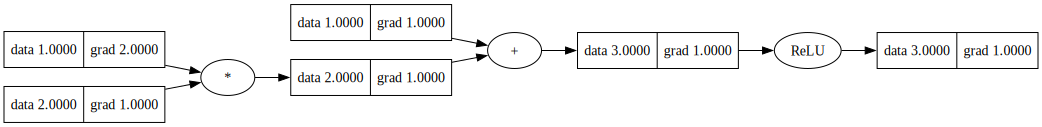

In [2]:
from graphviz import Digraph
from engine import Value


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):

    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)
